## 残差网络ResNet

随着我们设计越来越深的网络，深刻理解“新添加的层如何提升神经网络的性能”变得至关重要。

更重要的是设计“更好的”网络的能力，使得添加层能增加网络的表示能力，而不仅仅是看起来不一样。

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
import sys
sys.path.append('..')
import utils
import d2l

### 1、函数类

<img src='https://zh-v2.d2l.ai/_images/functionclasses.svg' style="zoom:100%;" />

圈代表网络能够表示的函数类范围；$F_1 \to F_6$网络逐层加深；$f^{*}$是我们想要学习到的函数；

我们通过迭代优化损失函数L，来在网络可表示的函数类中，学习到一个近似最优的$f_{F}^{*}$；但从图中可以看到，网络的加深，并不一定能够使$f_F^{*}$离$f^{*}$更近！

- 对于深度神经网络，如果我们能将新添加的层训练成恒等映射（identity function）$f(x) = x$，至少训练出来的效果不会比添加新层之前差； 
- 同时，由于新模型可能得出更优的解来拟合训练数据集，因此添加层似乎更容易降低训练误差。

何凯明等，2015年ImageNet图像识别挑战赛。

### 2、残差块

#### 2.1、ResNet中的残差块

In [3]:
class Residual(nn.Module):  #@save
    '''
    残差块

    Parameters:
    - input_channels: 输入的通道数
    - num_channels: 残差块所有层的统一输出通道数
    - use_1x1conv: 并行通路改用1x1卷积
    - strides: 残差块第一层的步幅（其他层步幅均为1）
    '''
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels, kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

<img src='https://d2l.ai/_images/resnet-block.svg' style="zoom:100%;" />

In [4]:
blk = Residual(3,3)
X = torch.rand(4, 3, 6, 6)
Y = blk(X)
Y.shape

torch.Size([4, 3, 6, 6])

右边那种残差块，可以修改两条通道的第一层卷积的输出通道数和stride，使得通道数加倍，同时高宽减半。

In [5]:
blk = Residual(3,6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

#### 2.2、残差块的扩展

<img src='./figs/8.jpg' style="zoom:30%;" />

### 3、ResNet模型

#### 3.1、ResNet块

- 高宽减半的Residual块，步幅为2（本层非必须）；
- 后接多个高宽不变的ResNet块。

<img src='./figs/9.jpg' style="zoom:40%;" />

In [9]:
def resnet_block(input_channels, num_channels, num_residuals, first_block=False):
    '''
    ResNet块
    
    Parameters:
    - input_channels: ResNet块输入的channel数
    - num_channels: ResNet块中Residual块的所有层的输出通道数
    - num_residuals: 所用的后续高宽不变的Residual块的个数
    - first_block: bool，是否为第一个ResNet块（否的话则需要通道数加倍，高宽减半）
    
    Return: list[Residual]
    '''
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels, use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

#### 3.2、ResNet架构

- 类似于VGG和GoogLeNet的总体架构；
- 替换Inception块成ResNet块。

<img src='https://d2l.ai/_images/resnet18.svg' style="zoom:70%;" />

In [10]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

主流就是7x7卷积加3x3池化，后面自己调整，最后接全局平均池化和一层全连接层；

In [12]:
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), nn.Linear(512, 10))

- 每个模块有4个卷积层（不包括恒等映射的 1×1 卷积层），加上第一个 7×7 卷积层和最后一个全连接层，共有18层。因此，这种模型通常被称为ResNet-18。
- 通过配置不同的通道数和模块里的残差块数可以得到不同的ResNet模型，例如更深的含152层的ResNet-152。
- 虽然ResNet的主体架构跟GoogLeNet类似，但ResNet架构更简单，修改也更方便。这些因素都导致了ResNet迅速被广泛使用。

In [13]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


### 4、训练

loss 0.017, train acc 0.995, test acc 0.880
6128.1 examples/sec on cuda:6


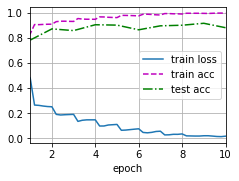

In [14]:
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, '../data', resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, utils.try_gpu(6))

明显的过拟合！稍微调整架构，缩减一下，应该会好很多。

而且加了batch normalization后，就会有这样的抖动出现，为什么？

### 5、小结

- Residual块使得很深的网络更加容易训练；
  - 甚至可以1000层！
- 残差网络对随后的深层神经网络设计产生了深远影响，无论是卷积类网络还是全连接网络。